# Thermal Block: heat diffusion
This tutorial is based on the [RBniCS tutorial](https://github.com/RBniCS/RBniCS/blob/master/tutorials/01_thermal_block/tutorial_thermal_block.ipynb). The domain is composed by a circle inside a square. The governing equation is the following with its BCs
\begin{equation}
\left\{
    \begin{array}{ll}
    \nabla \cdot \left(k\cdot \nabla \theta\right)=0 & \text{ in }\Omega\\
    \theta =  0 & \text{ on } \Gamma_{top}\\
    k\nabla\theta = 0 & \text{ on }\Gamma_{side}\\
    k\nabla\theta = \mu_1 & \text{ on }\Gamma_{bottom}
    \end{array}
\right.
\end{equation}
given $\mu_1$ a given parameter.

Two different cases will be considered: 
- $k$ constant and different for the circle $\Omega_1$ and the rest $\Omega \setminus \Omega_1$
- $k$ dependent on $\theta$ introducing a non-linearity

In [19]:
import dolfinx
from dolfinx.io import gmshio, XDMFFile
from mpi4py import MPI

import numpy as np
import pandas as pd
import time

from tqdm import tqdm

import ufl
from dolfinx import plot, fem, mesh
from dolfinx.fem import (Function, FunctionSpace, assemble_scalar, form, 
                        locate_dofs_topological, dirichletbc, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_rectangle, CellType, locate_entities_boundary
from ufl import grad, inner, div, conj, real, imag, Dx, nabla_grad, dot

from petsc4py import PETSc
from slepc4py import SLEPc

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams

rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

import dolfinx.plot
import pyvista as pv
pv.set_jupyter_backend("pythreejs")

class fenics_plot():
    def __init__(self, domain, tdim):
        self.domain = domain
        topology, cell_types, self.geometry = dolfinx.plot.create_vtk_mesh(domain, tdim)
        self.grid = pv.UnstructuredGrid(topology, cell_types, self.geometry)
        self.P1 = FunctionSpace(domain, ("CG", 1))

    def plot_mesh(self, resolution = [1080, 720]):
        plotter = pv.Plotter(off_screen = True)
        plotter.add_mesh(self.grid, show_edges=True)
        plotter.view_xy()
        #if not pv.OFF_SCREEN:
        #    plotter.show()
        plotter.screenshot('mesh.png', transparent_background = True,  window_size=resolution)
    
    def plot_scalar(self, fun, varname, filename, colormap = cm.turbo, resolution= [1440, 960]):
        uh = Function(self.P1)
        uh.interpolate(fem.Expression(fun, self.P1.element.interpolation_points()))
        u_topology, u_cell_types, u_geometry = dolfinx.plot.create_vtk_mesh(self.P1)
        u_grid = pv.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
        u_grid.point_data[varname] = uh.x.array.real
        u_grid.set_active_scalars(varname)
        u_plotter = pv.Plotter(off_screen = True)
        u_plotter.add_mesh(u_grid,  cmap = colormap, show_edges=False)
        u_plotter.view_xy()
        # if not pv.OFF_SCREEN:
        #     u_plotter.show()        
        u_plotter.screenshot(filename+'.png', transparent_background = True,  window_size=resolution)

## Preamble
The geometry and the main physical parameters will be assigned.

### Mesh Import
The geometry and the mesh are imported from "TWIGL2D.msh", generated with GMSH.

In [20]:
gdim = 2

domain, ct, ft = gmshio.read_from_msh("../../../mesh/thermal_block.msh", MPI.COMM_WORLD, gdim = gdim)

omega1_marker = 1
omega2_marker = 2

top_bound_marker  = 10
side_bound_marker = 20
bott_bound_marker = 30

Info    : Reading '../../../mesh/thermal_block.msh'...
Info    : 12 entities
Info    : 3487 nodes
Info    : 6972 elements
Info    : Done reading '../../../mesh/thermal_block.msh'


2023-02-02 18:16:01.041 ( 558.607s) [main            ]              utils.cpp:612   INFO| Compute partition of cells across ranks
2023-02-02 18:16:01.041 ( 558.607s) [main            ]         graphbuild.cpp:533   INFO| Building mesh dual graph
2023-02-02 18:16:01.041 ( 558.607s) [main            ]         graphbuild.cpp:396   INFO| Build local part of mesh dual graph
2023-02-02 18:16:01.046 ( 558.612s) [main            ]         graphbuild.cpp:89    INFO| Build nonlocal part of mesh dual graph
2023-02-02 18:16:01.046 ( 558.612s) [main            ]         graphbuild.cpp:545   INFO| Graph edges (local: 20516, non-local: 0)
2023-02-02 18:16:01.046 ( 558.612s) [main            ]       partitioners.cpp:522   INFO| Compute graph partition using ParMETIS
2023-02-02 18:16:01.046 ( 558.612s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 1
2023-02-02 18:16:01.046 ( 558.612s) [main            ]             

### Definition of the functional space and boundary conditions
The following lines are used to import all the necessary libraries, define the functional space and the boundary conditions.

In [21]:
tdim = domain.topology.dim

fdim = tdim - 1

ds = ufl.Measure("ds", domain=domain, subdomain_data=ft)
dx = ufl.Measure("dx", domain=domain, subdomain_data=ct)

domain.topology.create_connectivity(fdim, tdim)

2023-02-02 18:16:01.129 ( 558.695s) [main            ]topologycomputation.cpp:786   INFO| Requesting connectivity 1 - 2


### Define parameter functions on the different regions
Since there are 4 subdomains in $\Omega$ (i.e., fuel-1, fuel-2, fuel-rod, reflector) the values of the parameters changes according to the region, therefore proper functions should be defined.

In [22]:
class parameterFun():
    def __init__(self, cell_tag, funSpace: FunctionSpace):
        self.regionMarker = []
        self.cell_tag = cell_tag
        self.funSpace = funSpace
    
    def add(self, region):
        self.regionMarker.append(region)

    def assign(self, value_vec, fun):
        for idx in range(len(self.regionMarker)):
            regionI = self.regionMarker[idx]
            region_cells = self.cell_tag.find(regionI)
            fun.x.array[region_cells] = np.full_like(region_cells, value_vec[idx], dtype=PETSc.ScalarType)
        
    
V_parameters = FunctionSpace(domain, ("DG", 0))
parameters = parameterFun(ct, V_parameters)
parameters.add(omega1_marker)
parameters.add(omega2_marker)

2023-02-02 18:16:01.182 ( 558.748s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:01.182 ( 558.748s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2023-02-02 18:16:01.182 ( 558.748s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:01.182 ( 558.748s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2023-02-02 18:16:01.182 ( 558.748s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:01.182 ( 558.748s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. 

## Linear parametric case
The case in which $k$ is dependent on the region is analysed, i.e.
\begin{equation}
k(\mu_0) = \left\{
    \begin{array}{ll}
        \mu_0 & \text{ in }\Omega_1\\
        1 & \text{ in }\Omega_\setminus \Omega_1
    \end{array}
    \right.
\end{equation}
The weak formulation of the problem can be derived by applying the integration by parts:
\begin{equation}
-\int_\Omega k\nabla \theta\cdot \nabla v\,d\Omega + \int_{\Gamma_{bottom}}\mu_1\,v\,d\sigma = 0
\end{equation}

In [23]:
class linear_poisson():
    def __init__(self, domain, ft, param_class):

        self.domain = domain
        self.ft = ft
        self.fdim = domain.geometry.dim - 1

        self.V = FunctionSpace(self.domain, ("CG", 1))

        self.param = param_class
        self.k = Function(param_class.funSpace)

        self.theta = ufl.TrialFunction(self.V)
        self.v = ufl.TestFunction(self.V)

    def assignBC(self, top, side, bott):
        
        self.top_mark  = top
        self.side_mark = side
        self.bott_mark = bott

        self.zero = Function(self.V)
        self.zero.x.set(0.)
        self.bc_top = dirichletbc(self.zero, locate_dofs_topological(self.V, self.fdim, self.ft.find(self.top_mark)))
        
        self.bcs = [self.bc_top]

        # Neumann BC
        self.neumann = Function(self.V)

    def assemble(self):

        self.lhs = dot(self.k * grad(self.theta), grad(self.v)) * dx
        self.rhs = dot(self.neumann, self.v) * ds(self.bott_mark)

        self.bilin = form(self.lhs)
        self.lin   = form(self.rhs)
        
        self.A = fem.petsc.create_matrix(self.bilin)
        self.b = fem.petsc.create_vector(self.lin)

        self.solver = PETSc.KSP().create(domain.comm)
        self.solver.setOperators(self.A)
        self.solver.setType(PETSc.KSP.Type.CG)
        self.solver.getPC().setType(PETSc.PC.Type.SOR)  
    
    def solve(self, mu_0, mu_1):

        # Neumann BC
        self.neumann.x.set(mu_1)

        # Assigning conductivity value
        k_value = np.array([mu_0, 1.])
        self.param.assign(k_value, self.k)

        self.A.zeroEntries()
        fem.petsc.assemble_matrix(self.A, self.bilin, bcs = self.bcs)
        self.A.assemble()  

        with self.b.localForm() as loc_b:
            loc_b.set(0)
        fem.petsc.assemble_vector(self.b, self.lin)
        # Apply Dirichlet boundary condition to the vector
        fem.petsc.apply_lifting(self.b, [self.bilin], [self.bcs])
        self.b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(self.b, self.bcs)

        # Solve linear problem
        solution = Function(self.V)
        self.solver.solve(self.b, solution.vector)
        solution.x.scatter_forward()  

        return solution

Let us solve the problem considering $\mu_0 = 0.1$ and $\mu_1 = 1$.

In [24]:
lin_therm = linear_poisson(domain, ft, parameters)
lin_therm.assignBC(top_bound_marker, side_bound_marker, bott_bound_marker)
lin_therm.assemble()

mu_0 = 2.
mu_1 = 1.

theta_lin = lin_therm.solve(mu_0, mu_1)

# Plotting the solution
plotting = fenics_plot(domain, tdim)
plotting.plot_scalar(theta_lin, 'T', 'lin_Poisson')

2023-02-02 18:16:01.274 ( 558.840s) [main            ]topologycomputation.cpp:746   INFO| Computing mesh entities of dimension 0
2023-02-02 18:16:01.274 ( 558.840s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:01.275 ( 558.841s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2023-02-02 18:16:01.275 ( 558.841s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:01.275 ( 558.841s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2023-02-02 18:16:01.275 ( 558.841s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 1

## Non-linear case
This case considers $k=k(\theta)$. The weak formulation of the problem can be derived by applying the integration by parts:
\begin{equation}
-\int_\Omega k(\theta)\nabla \theta\cdot \nabla v\,d\Omega + \int_{\Gamma_{bottom}}\mu_1\,v\,d\sigma = 0
\end{equation}
However, this formulation is non-linear! A fixed point method is set up, given an initial guess for the temperature $\theta^{(0)}$, the weak formulation reads for $i>0$:
\begin{equation}
-\int_\Omega k\left(\theta^{(i-1)}\right)\nabla \theta^{(i)}\cdot \nabla v\,d\Omega + \int_{\Gamma_{bottom}}\mu_1\,v\,d\sigma = 0
\end{equation}

The dependence of the thermal conductivity is the following

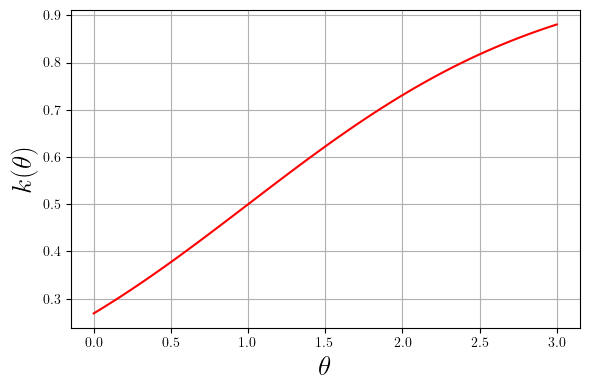

In [25]:
T_sample = np.linspace(0, 3, 100)
k_sample = 1. / (1 + np.exp( - (T_sample - 1)))

fig = plt.figure(figsize = (6,4))
plt.plot(T_sample, k_sample,'r')

plt.xlabel(r'$\theta$', fontsize = 20)
plt.ylabel(r"$k(\theta)$", fontsize = 20)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.tight_layout()

In [26]:
def thCond(T):
    return 1. / (1. + ufl.exp( - (T - 1)))

class update_conductivity():
    def __init__(self, domain):

        self.domain = domain
        self.ft = ft
        self.fdim = domain.geometry.dim - 1

        self.V_P1 = FunctionSpace(self.domain, ("CG", 1))
        self.T = Function(self.V_P1)

        self.V = FunctionSpace(self.domain, ("DG", 0))
        self.u   = ufl.TrialFunction(self.V)
        self.phi = ufl.TestFunction(self.V)

    def assemble(self):

        self.lhs = dot(self.u, self.phi) * dx
        self.rhs = dot(thCond(self.T), self.phi) * dx
        
        self.bilin = form(self.lhs)
        self.lin   = form(self.rhs)
        
        self.A = fem.petsc.assemble_matrix(self.bilin)
        self.A.assemble()
        self.b = fem.petsc.create_vector(self.lin)

        self.solver = PETSc.KSP().create(domain.comm)
        self.solver.setOperators(self.A)
        self.solver.setType(PETSc.KSP.Type.CG)
        self.solver.getPC().setType(PETSc.PC.Type.SOR)  
    
    def solve(self, T_guess):

        self.T.x.array[:] = T_guess.x.array[:]
        
        with self.b.localForm() as loc_b:
            loc_b.set(0)
        fem.petsc.assemble_vector(self.b, self.lin)
        self.b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)

        # Solve linear problem
        solution = Function(self.V)
        self.solver.solve(self.b, solution.vector)
        solution.x.scatter_forward()  

        return solution


class non_linear_poisson():
    def __init__(self, domain, ft):

        self.domain = domain
        self.ft = ft
        self.fdim = domain.geometry.dim - 1

        self.V_dg = FunctionSpace(self.domain, ("DG", 0))
        self.k = Function(self.V_dg)

        self.V = FunctionSpace(self.domain, ("CG", 1))
        self.T_guess = Function(self.V)
        self.theta = ufl.TrialFunction(self.V)
        self.v = ufl.TestFunction(self.V)

    def assignBC(self, top, side, bott):
        
        self.top_mark  = top
        self.side_mark = side
        self.bott_mark = bott

        self.zero = Function(self.V)
        self.zero.x.set(0.)
        self.bc_top = dirichletbc(self.zero, locate_dofs_topological(self.V, self.fdim, self.ft.find(self.top_mark)))
        
        self.bcs = [self.bc_top]

        # Neumann BC
        self.neumann = Function(self.V)

    def assemble(self):

        self.lhs = dot(self.k * grad(self.theta), grad(self.v)) * dx
        self.rhs = dot(self.neumann, self.v) * ds(self.bott_mark)

        self.bilin = form(self.lhs)
        self.lin   = form(self.rhs)
        
        self.A = fem.petsc.create_matrix(self.bilin)
        self.b = fem.petsc.create_vector(self.lin)

        self.solver = PETSc.KSP().create(domain.comm)
        self.solver.setOperators(self.A)
        self.solver.setType(PETSc.KSP.Type.GMRES)
        self.solver.getPC().setType(PETSc.PC.Type.ILU)  

        self.update_k = update_conductivity(self.domain)
        self.update_k.assemble()
    
    def solve(self, T_guess_value, mu_1, tol = 1e-4, maxIter = 500):

        # Setting up first guess
        self.T_guess.x.set(T_guess_value)

        # Neumann BC
        self.neumann.x.set(mu_1)

        error = 1.
        err_list = []
        ii = 0

        # Under-relax fraction
        alpha = 0.9

        while error > tol:
            self.k.interpolate(fem.Expression(self.update_k.solve(self.T_guess), self.V_dg.element.interpolation_points() ))

            self.A.zeroEntries()
            fem.petsc.assemble_matrix(self.A, self.bilin, bcs = self.bcs)
            self.A.assemble()  

            with self.b.localForm() as loc_b:
                loc_b.set(0)
            fem.petsc.assemble_vector(self.b, self.lin)
            # Apply Dirichlet boundary condition to the vector
            fem.petsc.apply_lifting(self.b, [self.bilin], [self.bcs])
            self.b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            fem.petsc.set_bc(self.b, self.bcs)

            # Solve linear problem
            theta_new = Function(self.V)
            self.solver.solve(self.b, theta_new.vector)
            theta_new.x.scatter_forward()  

            # Compute error in L2
            if ii > 0:
                error = np.sqrt(assemble_scalar(form( dot(theta_new - self.T_guess, theta_new - self.T_guess) * dx)))
                error /= np.sqrt(assemble_scalar(form( dot(theta_new, theta_new) * dx)))
                print(f'Iter {ii+0:03} | Abs L2 Error: {error :.3e}')
                err_list.append(error)
            ii += 1

            # u_old = (1-alpha) * u_new + alpha * u_old
            self.T_guess.vector.axpby(1-alpha, alpha, theta_new.vector)
            # self.T_guess.x.array[:] = theta_new.x.array[:]

            if ii > maxIter:
                print('Max iteration reached! Exiting loop')
                error = 0

        return theta_new, err_list

In [27]:
NL_poisson = non_linear_poisson(domain, ft)
NL_poisson.assignBC(top_bound_marker, side_bound_marker, bott_bound_marker)
NL_poisson.assemble()

theta_NL, err_list_NL = NL_poisson.solve(1., mu_1, tol = 1e-6)
plotting.plot_scalar(theta_NL, 'T_NL', 'T_NL')

# fig = plt.figure(figsize = (6,4))
# plt.loglog(err_list_NL,'b', label = r'Error')
# h_1 = np.arange(1,len(err_list_NL))
# plt.plot(h_1, 1. / h_1**2, 'r-.', label = r'$i^{-2}$')
# plt.ylabel(r'$\varepsilon$', fontsize = 20)
# plt.xlabel(r"Iteration $i$", fontsize = 20)
# plt.grid(which='major',linestyle='-')
# plt.grid(which='minor',linestyle='--')
# plt.xlim(1, len(err_list_NL))
# plt.legend()
# plt.tight_layout()

2023-02-02 18:16:02.109 ( 559.675s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:02.109 ( 559.675s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2023-02-02 18:16:02.109 ( 559.675s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:02.109 ( 559.675s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2023-02-02 18:16:02.109 ( 559.675s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:02.109 ( 559.675s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. 

Iter 001 | Abs L2 Error: 5.829e-01
Iter 002 | Abs L2 Error: 5.142e-01
Iter 003 | Abs L2 Error: 4.543e-01
Iter 004 | Abs L2 Error: 4.019e-01
Iter 005 | Abs L2 Error: 3.559e-01
Iter 006 | Abs L2 Error: 3.155e-01
Iter 007 | Abs L2 Error: 2.800e-01
Iter 008 | Abs L2 Error: 2.486e-01
Iter 009 | Abs L2 Error: 2.208e-01
Iter 010 | Abs L2 Error: 1.963e-01
Iter 011 | Abs L2 Error: 1.745e-01
Iter 012 | Abs L2 Error: 1.551e-01
Iter 013 | Abs L2 Error: 1.378e-01
Iter 014 | Abs L2 Error: 1.225e-01
Iter 015 | Abs L2 Error: 1.088e-01
Iter 016 | Abs L2 Error: 9.661e-02
Iter 017 | Abs L2 Error: 8.574e-02
Iter 018 | Abs L2 Error: 7.606e-02
Iter 019 | Abs L2 Error: 6.743e-02
Iter 020 | Abs L2 Error: 5.973e-02
Iter 021 | Abs L2 Error: 5.288e-02
Iter 022 | Abs L2 Error: 4.678e-02
Iter 023 | Abs L2 Error: 4.135e-02
Iter 024 | Abs L2 Error: 3.652e-02
Iter 025 | Abs L2 Error: 3.222e-02
Iter 026 | Abs L2 Error: 2.841e-02
Iter 027 | Abs L2 Error: 2.502e-02
Iter 028 | Abs L2 Error: 2.202e-02
Iter 029 | Abs L2 Er

## Newton solver
The built-in Newotn solver is used.

In [28]:
class newton_poisson():
    def __init__(self, domain, ft):

        self.domain = domain
        self.ft = ft
        self.fdim = domain.geometry.dim - 1

        self.V = FunctionSpace(self.domain, ("CG", 1))


        self.theta = Function(self.V)
        self.v = ufl.TestFunction(self.V)

    def assignBC(self, top, side, bott):
        
        self.top_mark  = top
        self.side_mark = side
        self.bott_mark = bott

        self.zero = Function(self.V)
        self.zero.x.set(0.)
        self.bc_top = dirichletbc(self.zero, locate_dofs_topological(self.V, self.fdim, self.ft.find(self.top_mark)))
        
        self.bcs = [self.bc_top]

        # Neumann BC
        self.neumann = Function(self.V)

    def assemble(self, tol = 1e-6):

        self.F = thCond(self.theta) * dot(grad(self.theta), grad(self.v)) * dx - dot(self.neumann, self.v) * ds(self.bott_mark)
        self.pb = fem.petsc.NonlinearProblem(self.F, self.theta, bcs=self.bcs)

        self.solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, self.pb)
        self.solver.convergence_criterion = "incremental"
        self.solver.rtol = tol
        self.solver.report = True

        self.ksp = self.solver.krylov_solver
        self.opts = PETSc.Options()
        option_prefix = self.ksp.getOptionsPrefix()
        self.opts[f"{option_prefix}ksp_type"] = "cg"
        self.opts[f"{option_prefix}pc_type"] = "gamg"
        self.opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
        self.ksp.setFromOptions()
    
    def solve(self, mu_1):

        # Neumann BC
        self.neumann.x.set(mu_1)


        dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
        n, converged = self.solver.solve(self.theta)
        assert(converged)
        print(f"Number of interations: {n:d}")

        return self.theta

In [29]:
newt_poisson = newton_poisson(domain, ft)
newt_poisson.assignBC(top_bound_marker, side_bound_marker, bott_bound_marker)
newt_poisson.assemble()

theta_newt = newt_poisson.solve(mu_1)
plotting.plot_scalar(theta_newt, 'T_newt', 'T_newt')

2023-02-02 18:16:07.858 ( 565.424s) [main            ]topologycomputation.cpp:746   INFO| Computing mesh entities of dimension 0
2023-02-02 18:16:07.859 ( 565.424s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:07.859 ( 565.425s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2023-02-02 18:16:07.859 ( 565.425s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 18:16:07.859 ( 565.425s) [main            ]                MPI.cpp:217   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2023-02-02 18:16:07.859 ( 565.425s) [main            ]                MPI.cpp:154   INFO| Computing communicaton graph edges (using NBX algorithm). Number of input edges: 0
2023-02-02 1

Number of interations: 5


2023-02-02 18:16:08.069 ( 565.635s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 5: r (abs) = 4.27706e-05 (tol = 1e-10) r (rel) = 1.79685e-07(tol = 1e-06)
2023-02-02 18:16:08.069 ( 565.635s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 5 iterations and 29 linear solver iterations.
